# Preamble

In order to fully understand the following analysis, some key terms must be defined.

- A **Correct Detection** of a synapse occurs when, after the binarization step, the pipeline identifies at least 1 voxel in a synapse cluster as synapse by scoring it with a 1. Each synapse cluster can only be correctly detected once

- An **Incorrect Detection** of a synapse occurs when, after the binarization step, the pipeline identifies a voxel as synapse by scoring it with a 1, even though said voxel is not in a ground truth synapse cluster.

- The **Probability of Detection (PD)** is the fraction $\frac{\text{Correct Detections}}{\text{True Number of Synapses}}$ This is the same formula as **Recall*

- The **False Alarm Rate (FAR)** is the fraction $\frac{\text{Incorrect Detections}}{\text{Total Detections}}$ This can be thought of as the **False Positive Rate**

# Simulation Data

## 1. Write Sampling Distributions
### Functionality Data
The easy case and failure case tests for our algorithm will utilize data that we have created for prior unit tests. These files will be loaded from pickle files on our repo.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import sys
sys.path.insert(0,'../code/functions/')

easySim = pickle.load(open('../code/tests/synthDat/twoPerfectClusters.synth'))
hardSim = pickle.load(open('../code/tests/synthDat/all100.synth'))


#### i.
For the easySim, I expect the algorithm to correctly identify both 'synapse' clusters in the data, and not identify any non synapse voxels as cluster. This will result in a **PD of 100%** and a **FAR of 0%**

For the hardSim, I expect the algorithm to identify both synapse clusters, and the noise in the data, as synapse. This would result in a **PD of 100% and a FAR of ~99%**

#### ii.
I expect the algorithm to perform very well on easySim, since the volume is small, and the clusters are not obscured by any noise.

I expect the algorithm to perform very poorly on the hardSim, since the volume is fully saturated with noise, and there is no way for the pipeline to differentiate synapse from noise.

### Validation Data

In addition to these base easy and difficult cases, we will generate data volumes with the following properties:

- 100x100x100 Voxels
- 98% Non-Synapse, 2% Synapse
- Synapses clustered into 2 micron$^3$ clusters

The code below will perform this generation routine

In [8]:
from random import randrange as rand
from skimage.measure import label

def generatePointSet():
    center = (rand(0, 99), rand(0, 99), rand(0, 99))
    toPopulate = []
    for z in range(-1, 2):
        for y in range(-1, 2):
            for x in range(-1, 2):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 100:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    for _ in range(rand(500, 800)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
    return volume, noiseVolume

#### i. 
The ground truth for each point set is returned as the first of two unpacked values from the generateTestVolume function. In this way, we can compare every test trial to the ground truth.

#### ii.
I expect the algorithm to perform very well on tihs data, since it was designed to filter out noise and identify synapses of the size in the synthetic data.

## 2. Write code to sample data

The above data can be sampled in one of three ways
1. Through the easySim variable
2. Through the hardSim variable
3. Though the generateTestVolume function

## 3. Describe in words what I expect the simulations to look like

Based on our prior testing, I expect a mean PD of ~97% and a mean ffar of 0% for the generateTestVolume Data. My expectations for the easySim and hardSim data can be found in **Simulation Data Section 1 - Functionality Testing - i**

## 4/5. Write code to plot and plot the sim data

### Functionality Data

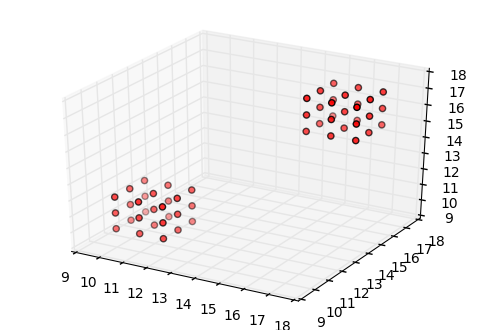

In [12]:
#The easy sim data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = easySim.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

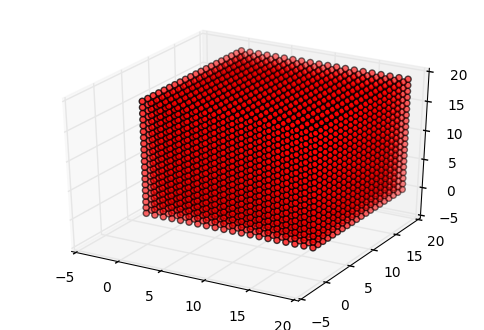

In [13]:
#The hard sim data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = hardSim.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

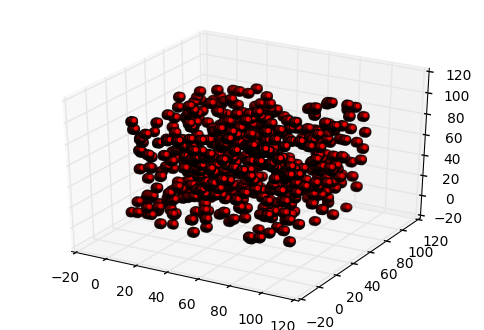

In [15]:
#One instance of generated data
truth, test = generateTestVolume()

#The ground truth data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = truth.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

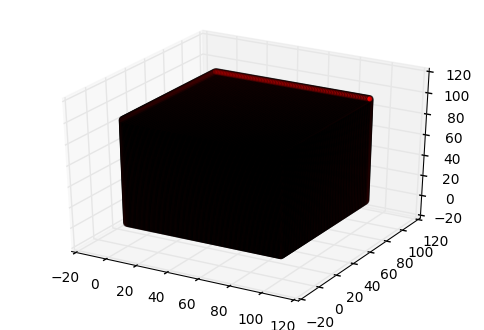

In [16]:
#The test data (has noise)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = test.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

In [31]:
synapseDensity = len(zip(*truth.nonzero()))/float(100*100*100)

def getAveSynSize(volume):
    lVolume = label(volume)
    aveSum = []
    #starting at 1 since we dont want to count the background label
    for i in range(1, np.max(lVolume)+1):
        aveSum.append(len(zip(*np.where(lVolume == i))))
    return np.average(aveSum), aveSum

print 'Percent Synapse by Volume: ', synapseDensity*100., '%'
aveSize, sizeList = getAveSynSize(truth)
print 'Average Synapse Size: ', aveSize

Percent Synapse by Volume:  1.5849 %
Average Synapse Size:  28.5053956835


In [ ]:
plt.figure()
plt.hist(sizeList)
